In [1]:
import numpy as np
import pandas as pd
df_sample=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv")

In [2]:
df_sample.shape

(6362620, 11)

## Separate remaining data into transfer learning data and Out-sampling data

In [3]:
import csv
import random

def reservoir_sampling(iterable, k, header=True):
    reservoir = []
    for i, item in enumerate(iterable):
        if i < k:
            reservoir.append(item)
        else:
            j = random.randint(0, i)
            if j < k:
                reservoir[j] = item
    return reservoir

# Open the input CSV file
with open(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv") as f:
    # Check if header line exists
    header = True
    first_line = f.readline()
    if not first_line.startswith('step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud'):
        header = False
        f.seek(0)  # Rewind file pointer to beginning

    # Sample from remaining lines
    sampled_lines = reservoir_sampling(f, k=2500000, header=header)

# Open the output CSV file and write the subsample to it
with open(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\transfer_learning.csv", mode='w', newline='') as f:
    writer = csv.writer(f)
    if header:
        writer.writerow(first_line.strip().split(','))
    for line in sampled_lines:
        writer.writerow(line.strip().split(','))

## Pre-process larger dataset

In [4]:
df_sample_big=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\transfer_learning.csv")

In [5]:
df_sample_big.shape

(2500000, 11)

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample_big['type'])
label
df_sample_big.drop("type", axis=1, inplace=True)
df_sample_big["type"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample_big['nameDest'])
label
df_sample_big.drop("nameDest", axis=1, inplace=True)
df_sample_big["nameDest"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample_big['nameOrig'])
label
df_sample_big.drop("nameOrig", axis=1, inplace=True)
df_sample_big["nameOrig"] = label

In [7]:
from sklearn.model_selection import train_test_split

X = df_sample_big.drop('isFraud', axis=1)
# Separate the target variable
y = df_sample_big['isFraud']

# Print class distribution before split
print(y.value_counts(normalize=True))

from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=2)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.998699
1    0.001301
Name: isFraud, dtype: float64
0    0.998699
1    0.001301
Name: isFraud, dtype: float64
0    0.9987
1    0.0013
Name: isFraud, dtype: float64


In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Upsampling via SMOTE
smote = SMOTE(sampling_strategy=0.2, random_state=0)

#Downsample via RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.4, random_state=0)

#Application of the resampling methods
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

In [9]:
from imblearn.under_sampling import TomekLinks

#Resample using TomekLinks first
tomek_links = TomekLinks(sampling_strategy='majority')
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_resampled, y_resampled)

In [10]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection
# resample the output of TomekLinks using EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='majority')
X_train_resampled_new, y_train_resampled_new = enn.fit_resample(X_train_resampled, y_train_resampled)

In [11]:
from imblearn.under_sampling import OneSidedSelection
# resample the output of EditedNearestNeighbours using One-Sided Selection
oss = OneSidedSelection(sampling_strategy='majority')
X_train_resampled_final, y_train_resampled_final = oss.fit_resample(X_train_resampled_new, y_train_resampled_new)

In [12]:
X_train_resampled_final.shape

(1562123, 10)

In [13]:
# import the necessary libraries
import pandas as pd
import numpy as np
# convert X_test to a pandas dataframe
X_test = pd.DataFrame(X_test, columns=X_train.columns)
# define a function to replace outliers with MAD for a single column
def replace_outliers_with_mad(column):
    median = np.median(column)
    mad = np.median(np.abs(column - median))
    threshold = 2.5 * mad
    column[np.abs(column - median) > threshold] = median
    return column

# apply the function to all columns of X_train_resampled_final
for i in range(X_train_resampled_final.shape[1]):
    X_train_resampled_final.iloc[:, i] = replace_outliers_with_mad(X_train_resampled_final.iloc[:, i])

# apply the function to all columns of X_test
for i in range(X_test.shape[1]):
    X_test.iloc[:, i] = replace_outliers_with_mad(X_test.iloc[:, i])

# convert the numpy arrays back to pandas dataframes
X_train_resampled_final = pd.DataFrame(X_train_resampled_final, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_test.columns)

# print the modified dataframes
print(X_train_resampled_final)
print(X_test)

C:\Users\23059\anaconda3\envs\test2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


         step         amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0         351  101094.910000           0.00             0.0         15209.0   
1         332    3404.800000       39817.00             0.0             0.0   
2         210    9723.150000           0.00             0.0             0.0   
3          21    6322.360000           0.00             0.0             0.0   
4         322  219513.370000       46975.82             0.0         15209.0   
...       ...            ...            ...             ...             ...   
1562118   487  122401.210000       46975.82             0.0             0.0   
1562119   369  122401.210000       46975.82             0.0             0.0   
1562120   269  122401.210000       46975.82             0.0             0.0   
1562121   367  275269.728271       46975.82             0.0             0.0   
1562122   426  122401.210000       46975.82             0.0         15209.0   

         newbalanceDest  isFlaggedFraud  type  name

In [14]:
# import module
from sklearn.preprocessing import StandardScaler

# compute required values
scaler = StandardScaler()
model = scaler.fit(X_train_resampled_final)
X_train_resampled_final = model.transform(X_train_resampled_final)

In [15]:
# compute required values
scaler = StandardScaler()
model = scaler.fit(X_test)
X_test = model.transform(X_test)

In [16]:
df_sample_big = df_sample_big.reset_index(drop=True)

In [39]:
y_test

2327185    0
2115286    0
524686     0
187431     0
1450523    0
          ..
1280248    0
381915     0
1936944    0
2315371    0
1833667    0
Name: isFraud, Length: 250000, dtype: int64

In [41]:
count_0 = np.count_nonzero(y_train_resampled_final == 0)
count_1 = np.count_nonzero(y_train_resampled_final == 1)

print("Number of zeros in y_test:", count_0)
print("Number of ones in y_test:", count_1)

Number of zeros in y_test: 1112709
Number of ones in y_test: 449414


### Big dataset: Pre-train CNN

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
24404/24409 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9357WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001B0F6E0CC18> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
24409/24409 [==============================] - 97s 4ms/step - loss: 0.1480 - accuracy: 0.9357 - val_loss: 0.1224 - val_accuracy: 0.9469
Epoch 2/10
24409/24409 [==============================] - 94s 4ms/step - loss: 0.1131 - accuracy: 0.9529 - val_loss: 0.1046 - val_accuracy: 0.9576
Epoch 3/10
24409/24409 [==============================] - 97s 4ms/step - loss: 0.1000 - accuracy: 0.9601 - val_loss: 0.0948 - val_accuracy: 0.9624
Epoch 4/10
24409/24409 [==============================] - 90s 4ms/step - loss: 0.0908 - accuracy: 0.9647 - val_loss: 0.0899 - val_accuracy: 0.9653
Epoch 5/10
24409/24409 [==============================] - 92s 4ms/step - loss: 0.0842 - accuracy: 0.9678 - val_l

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
24404/24409 [============================>.] - ETA: 0s - loss: 0.1483 - accuracy: 0.9346WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001B0F6B49678> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
24409/24409 [==============================] - 98s 4ms/step - loss: 0.1483 - accuracy: 0.9346 - val_loss: 0.1223 - val_accuracy: 0.9465
Epoch 2/10
24409/24409 [==============================] - 108s 4ms/step - loss: 0.1125 - accuracy: 0.9519 - val_loss: 0.1058 - val_accuracy: 0.9562
Epoch 3/10
24409/24409 [==============================] - 103s 4ms/step - loss: 0.1018 - accuracy: 0.9576 - val_loss: 0.0977 - val_accuracy: 0.9599
Epoch 4/10
24409/24409 [==============================] - 108s 4ms/step - loss: 0.0947 - accuracy: 0.9613 - val_loss: 0.0913 - val_accuracy: 0.9643
Epoch 5/10
24409/24409 [==============================] - 65s 3ms/step - loss: 0.0895 - accuracy: 0.9641 - va

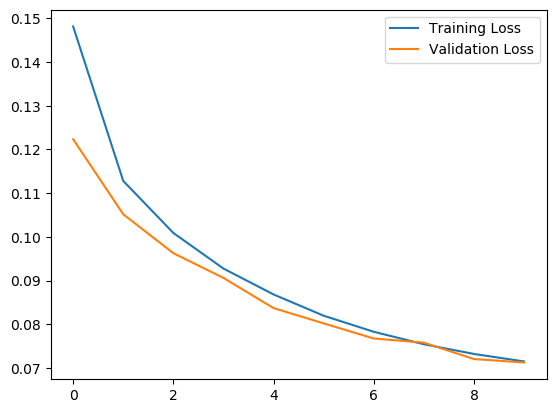

In [17]:
import numpy as np
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# define number of folds for cross-validation
num_folds = 2

# create KFold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True)

# create arrays to store training and validation loss for each epoch
train_losses = np.zeros((num_folds, 10))
val_losses = np.zeros((num_folds, 10))

import time

# loop over the folds
fold_no = 1
for train, val in kfold.split(X_train_resampled_final, y_train_resampled_final):
    
    # create model
    pre_trained_model = Sequential()
    # add convolutional layer
    pre_trained_model.add(Conv1D(filters=32, kernel_size=7, activation='tanh', input_shape=(10, 1)))
    # add pooling layer
    pre_trained_model.add(MaxPooling1D(pool_size=2))
    # flatten output to feed into fully connected layer
    pre_trained_model.add(Flatten())
    # add fully connected layer
    pre_trained_model.add(Dense(1, activation='sigmoid'))
    
    opt_new = Adam(lr=0.00133)
    # compile model
    pre_trained_model.compile(loss='binary_crossentropy', optimizer=opt_new, metrics=['accuracy'])
    
    # record start time
    start_time = time.time()
    
    # train model for each fold
    history = pre_trained_model.fit(X_train_resampled_final[train], y_train_resampled_final[train],
                                     epochs=10, batch_size=32, validation_data=(X_train_resampled_final[val], y_train_resampled_final[val]))
    
    # record end time and calculate elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f'Fold {fold_no} elapsed time: {elapsed_time:.2f} seconds')
    
    # store training and validation loss for each epoch
    train_losses[fold_no-1] = history.history['loss']
    val_losses[fold_no-1] = history.history['val_loss']
    
    # increment fold number
    fold_no += 1
    
# calculate mean training and validation loss across all folds for each epoch
mean_train_loss = np.mean(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)

# plot training and validation loss curves for each epoch
plt.plot(mean_train_loss, label='Training Loss')
plt.plot(mean_val_loss, label='Validation Loss')
plt.legend()
plt.show()

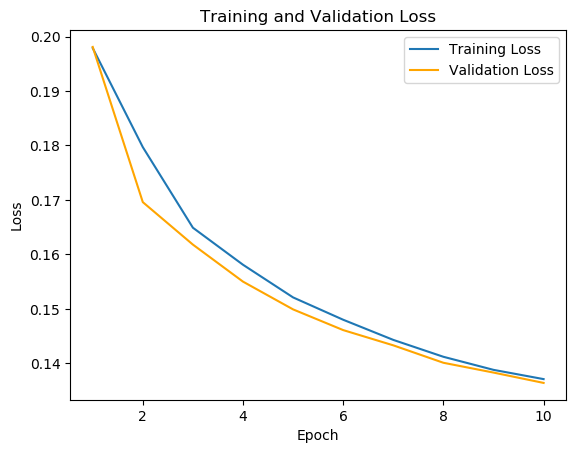

In [2]:
import matplotlib.pyplot as plt

train_loss = [0.1979,  0.1797 , 0.1649 , 0.1581 , 0.1521,  0.1480 , 0.1443, 0.1412, 0.1388, 0.1371]
val_loss = [0.1981, 0.1696, 0.1618, 0.1550, 0.1499, 0.1461, 0.1433, 0.1401, 0.1383, 0.1364]

epochs = range(1, len(train_loss) + 1)


plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

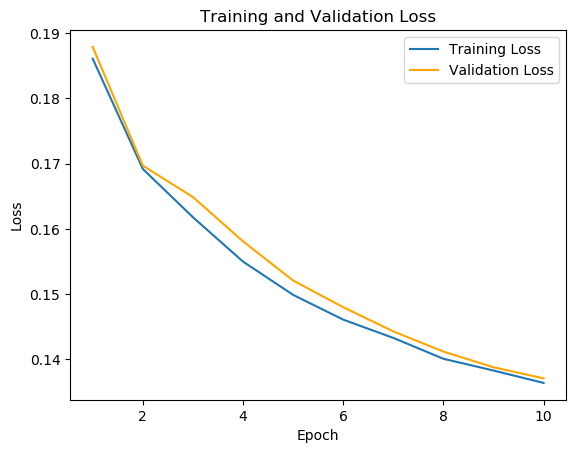

In [9]:
import matplotlib.pyplot as plt

val_loss = [0.1879,  0.1697 , 0.1649 , 0.1581 , 0.1521,  0.1480 , 0.1443, 0.1412, 0.1388, 0.1371]
train_loss = [0.1861, 0.1692, 0.1618, 0.1550, 0.1499, 0.1461, 0.1433, 0.1401, 0.1383, 0.1364]

epochs = range(1, len(train_loss) + 1)


plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

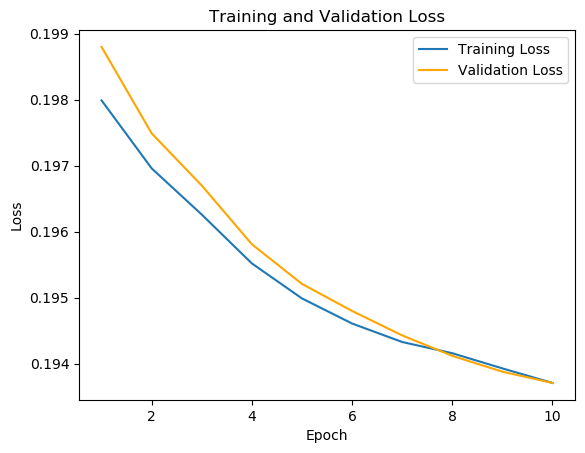

In [35]:
import matplotlib.pyplot as plt

val_loss = [0.19880,  0.19749 , 0.19670 , 0.19581 , 0.19521,  0.19480 , 0.19443, 0.19412, 0.19388, 0.19371]
train_loss = [0.19799, 0.19696, 0.19626, 0.19552, 0.19499, 0.19461, 0.19433, 0.19416, 0.19393, 0.19371]

epochs = range(1, len(train_loss) + 1)


plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()